# NBA Winner Classifier

## Imports

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#pd.options.display.max_columns = None
#pd.set_option("display.max_colwidth", None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option("display.max_rows", None)
import model.train as train
import model.config as model_config
import utils
import model.dataset.season_game as sg
import utils_nba_winner_clf as utils_exp
import qgrid
from yellowbrick import classifier, features
from pandas_profiling import ProfileReport

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

## Setup

In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

sns.set(style="whitegrid", palette="husl")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Utils functions

In [54]:
def del_exp_result(exp_name):
    for idx, res in enumerate(list(utils_exp.exp_results)):
        if res['exp_name'] == exp_name:
            del utils_exp.exp_results[idx]

In [34]:
def show_qgrid(df_):
    qgrid_widget = qgrid.show_grid(df_, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
    qgrid_widget

In [20]:
def plot_results(experiment_name, results, figsize=(20,10)):
    plt.figure(figsize=figsize)
    results_df = utils.map_results_to_df(results)
    a = sns.pointplot(data=results_df,
              kind="point", x="season_test", y="balanced_accuracy", hue="model"
              )
    a.set_title(
        f"{experiment_name}-balanced_accuracy")
    a.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [21]:
def get_results_df():
    return pd.DataFrame(utils_exp.exp_results)

In [22]:
metrics = ['precision', 'balanced_accuracy', 'recall', 'f1', 'roc_auc']

def print_prettier_exp_results(exp_name, metric='roc_auc'):
    ba_df = get_results_df()[['exp_name', 'model',
       f'{metric}_mean', f'{metric}_std']]
    return ba_df[ba_df.exp_name == exp_name].sort_values(by=[f"{metric}_mean"], ascending=False)

## Load Dataset

In [23]:
season_games = sg.load_season_games_dataset()

## EDA

In [13]:
eda_df = season_games

In [14]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21646 entries, 0020200001 to 0021901318
Columns: 176 entries, SEASON_ID to HOME_POINT_SPREAD
dtypes: float64(126), int64(39), object(11)
memory usage: 29.2+ MB


In [15]:
eda_df.describe()

,TEAM_ID_HOME,MIN_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,...,REB_L10_AWAY,AST_L10_AWAY,STL_L10_AWAY,BLK_L10_AWAY,TOV_L10_AWAY,PF_L10_AWAY,PTS_L10_AWAY,PLUS_MINUS_L10_AWAY,HOME_WINS,HOME_POINT_SPREAD
count,2.164600e+04,21646.000000,21646.000000,21646.000000,21646.000000,21646.000000,21646.000000,21646.000000,21646.000000,21646.000000,...,21646.000000,21646.000000,21646.000000,21646.000000,21646.000000,21646.000000,21646.000000,21646.000000,21646.000000,21646.000000
mean,1.610613e+09,241.807493,38.053867,82.732098,0.460948,7.570082,20.996628,0.357365,18.590640,24.485540,...,42.535768,21.823919,7.577665,4.869551,14.539762,21.102605,100.510239,-0.287958,0.594613,2.969325
std,8.623953e+00,7.583848,5.335071,7.813640,0.056462,3.836670,8.401484,0.115589,6.318934,7.798392,...,3.030974,2.710392,1.337221,1.181640,1.834785,2.305682,7.678851,6.293498,0.490978,13.191697
min,1.610613e+09,240.000000,19.000000,56.000000,0.250000,0.000000,1.000000,0.000000,1.000000,1.000000,...,25.000000,8.000000,1.000000,0.000000,6.000000,13.900000,59.000000,-33.000000,0.000000,-56.000000
25%,1.610613e+09,240.000000,34.000000,77.000000,0.422000,5.000000,15.000000,0.286000,14.000000,19.000000,...,40.500000,20.000000,6.700000,4.100000,13.300000,19.500000,95.200000,-4.500000,0.000000,-6.000000
50%,1.610613e+09,240.000000,38.000000,82.000000,0.460000,7.000000,20.000000,0.357000,18.000000,24.000000,...,42.400000,21.600000,7.500000,4.800000,14.500000,21.000000,100.000000,-0.300000,1.000000,4.000000
75%,1.610613e+09,240.000000,42.000000,88.000000,0.500000,10.000000,26.000000,0.429000,23.000000,29.750000,...,44.500000,23.500000,8.400000,5.600000,15.700000,22.600000,105.400000,3.900000,1.000000,11.000000
max,1.610613e+09,340.000000,62.000000,125.000000,0.684000,27.000000,70.000000,1.000000,48.000000,64.000000,...,59.000000,36.000000,16.000000,15.000000,27.000000,42.000000,131.100000,48.000000,1.000000,61.000000


In [18]:
eda_df["WIN"] = ["HOME" if x == 1 else "VISITOR" for x in eda_df['HOME_WINS']]

In [19]:
eda_df["WIN"].value_counts()

HOME       12871
VISITOR     8775
Name: WIN, dtype: int64

### Pandas Profiling

In [ ]:
profile = ProfileReport(eda_df, title='Pandas Profiling Report', pool_size=4,
                        minimal=True,
                        explorative=True,
                           correlations={
             "pearson": {"calculate": True},
             "spearman": {"calculate": True},
             "kendall": {"calculate": True},
             "phi_k": {"calculate": False},
             "cramers": {"calculate": False},
         })
profile.to_file("season_games_pd_report.html")

### By Team

In [23]:
last_season = eda_df[eda_df.SEASON == 2018]
last_season.head()

,GAME_DATE_EST,HOME_TEAM_NAME,HOME_TEAM_ID,VISITOR_TEAM_NAME,VISITOR_TEAM_ID,SEASON,HT_RANK,HT_CLASS,HT_HW,HT_HL,...,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,WIN
GAME_ID,,,,,,,,,,,,,,,,,,,,,
21800001,2018-10-16,BOS,1610612738,PHI,1610612755,2018,29,2,0,0,...,21.0,55.0,87.0,0.391,0.609,0.192,18.0,47.0,1,HOME
21800002,2018-10-16,GSW,1610612744,OKC,1610612760,2018,28,2,0,0,...,28.0,58.0,100.0,0.363,0.649,0.270,21.0,45.0,1,HOME
21800003,2018-10-17,CHA,1610612766,MIL,1610612749,2018,16,1,0,0,...,21.0,41.0,113.0,0.494,0.750,0.412,26.0,57.0,0,VISITOR
21800004,2018-10-17,DET,1610612765,BKN,1610612751,2018,20,2,0,0,...,21.0,46.0,100.0,0.488,0.682,0.185,28.0,39.0,1,HOME
21800005,2018-10-17,IND,1610612754,MEM,1610612763,2018,26,2,0,0,...,29.0,57.0,83.0,0.298,0.821,0.345,16.0,28.0,1,HOME


In [24]:
home_wins_df = last_season[["HOME_TEAM_NAME", "HOME_TEAM_WINS"]].groupby(by="HOME_TEAM_NAME") \
.agg({'HOME_TEAM_NAME':'count', 'HOME_TEAM_WINS': 'sum'}) \
.sort_values(by=["HOME_TEAM_WINS"], ascending=False)
home_wins_df["TEAM_LOSS"] = home_wins_df["HOME_TEAM_NAME"] - home_wins_df["HOME_TEAM_WINS"]
home_wins_df.drop(labels=["HOME_TEAM_NAME"], axis=1, inplace=True)
home_wins_df.rename(columns={"HOME_TEAM_WINS": "TEAM_WINS"}, inplace=True)
home_wins_df.index.rename("TEAM_NAME", inplace=True)
home_wins_df

,TEAM_WINS,TEAM_LOSS
TEAM_NAME,,
DEN,34,7
MIL,33,8
SAS,32,9
POR,32,9
TOR,32,9
PHI,31,10
HOU,31,10
GSW,30,11
IND,29,12


In [25]:
visitor_wins_df = last_season[["VISITOR_TEAM_NAME", "HOME_TEAM_WINS"]].groupby(by="VISITOR_TEAM_NAME") \
.agg({'VISITOR_TEAM_NAME':'count', 'HOME_TEAM_WINS': 'sum'}) \
.sort_values(by=["HOME_TEAM_WINS"], ascending=False)
visitor_wins_df["TEAM_WINS"] = visitor_wins_df["VISITOR_TEAM_NAME"] - visitor_wins_df["HOME_TEAM_WINS"]
visitor_wins_df.rename(columns={"HOME_TEAM_WINS": "TEAM_LOSS"}, inplace=True)
visitor_wins_df.drop(labels=["VISITOR_TEAM_NAME"], axis=1, inplace=True)
visitor_wins_df.index.rename("TEAM_NAME", inplace=True)
#visitor_wins_df = visitor_wins_df[["TEAM_WINS"]]
visitor_wins_df = visitor_wins_df[["TEAM_WINS", "TEAM_LOSS"]]
visitor_wins_df

,TEAM_WINS,TEAM_LOSS
TEAM_NAME,,
CLE,6,35
PHX,7,34
NYK,8,33
DAL,9,32
WAS,10,31
MIN,11,30
MEM,12,29
ATL,12,29
CHI,13,28


In [26]:
home_wins_df.combine(visitor_wins_df, lambda s1, s2: s1 + s2).sort_values(by="TEAM_WINS", ascending=False)

,TEAM_WINS,TEAM_LOSS
TEAM_NAME,,
MIL,60,22
TOR,58,24
GSW,57,25
DEN,54,28
HOU,53,29
POR,53,29
PHI,51,31
UTA,50,32
BOS,49,33


In [27]:
mil_df = last_season[(last_season.VISITOR_TEAM_NAME == 'MIL') | (last_season.HOME_TEAM_NAME == 'MIL')]
mil_df['GAME_N'] = range(1, 83,1)
mil_df

/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,GAME_DATE_EST,HOME_TEAM_NAME,HOME_TEAM_ID,VISITOR_TEAM_NAME,VISITOR_TEAM_ID,SEASON,HT_RANK,HT_CLASS,HT_HW,HT_HL,...,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,WIN,GAME_N
GAME_ID,,,,,,,,,,,,,,,,,,,,,
21800003,2018-10-17,CHA,1610612766,MIL,1610612749,2018,16,1,0,0,...,41.0,113.0,0.494,0.750,0.412,26.0,57.0,0,VISITOR,1
21800023,2018-10-19,MIL,1610612749,IND,1610612754,2018,24,2,0,0,...,50.0,101.0,0.437,0.704,0.333,14.0,41.0,1,HOME,2
21800042,2018-10-22,MIL,1610612749,NYK,1610612752,2018,27,2,1,0,...,55.0,113.0,0.455,0.867,0.345,22.0,43.0,1,HOME,3
21800059,2018-10-24,MIL,1610612749,PHI,1610612755,2018,27,2,2,0,...,51.0,108.0,0.413,0.700,0.324,29.0,50.0,1,HOME,4
21800071,2018-10-26,MIN,1610612750,MIL,1610612749,2018,7,0,2,0,...,49.0,125.0,0.533,0.727,0.413,32.0,62.0,0,VISITOR,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21801154,2019-04-01,BKN,1610612751,MIL,1610612749,2018,15,1,22,16,...,55.0,131.0,0.500,0.867,0.324,28.0,40.0,0,VISITOR,78
21801177,2019-04-04,PHI,1610612755,MIL,1610612749,2018,23,2,30,9,...,43.0,128.0,0.452,0.744,0.353,26.0,50.0,0,VISITOR,79
21801193,2019-04-06,MIL,1610612749,BKN,1610612751,2018,29,2,32,6,...,43.0,133.0,0.495,0.783,0.422,25.0,43.0,0,VISITOR,80


In [28]:
#sns.regplot(x=mil_df["GAME_N"], y=mil_df["GAME_N"])
#sns.catplot(data=mil_df[["HOME_TEAM_NAME", "GAME_N", "WIN"]],  x="GAME_N", y="HOME_TEAM_NAME", kind="bar", hue="WIN", palette="Set2")
#sns.displot(data=mil_df, x="GAME_N", hue="WIN", multiple="stack")
#plt.show()


### Scatter plot

## Dataset


In [26]:
season_games.groupby(by="SEASON").count()["GAME_DATE_EST"]

SEASON
2002    1189
2003    1189
2004    1230
2005    1230
2006    1230
2007    1230
2008    1230
2009    1230
2010    1230
2011     990
2012    1229
2013    1230
2014    1230
2015    1230
2016    1230
2017    1230
2018    1230
2019    1059
Name: GAME_DATE_EST, dtype: int64

Podemos observar que no todas las temporadas tiene la misma cantidad de partidos. Esto es debido a la siguientes razones:

- 2011: Los jugadores hicieron una huelga debido a no estar de acuerdo con los salarios de los mismos y el limite salarial de las franquicias.
- 2012: Un partido entre el equipo de Boston e Indiana fue suspedindo el cual despues no fue reprogramado, y al final de la temporada se decidio ya no reprogramarlo debido a que la clasificacion a playoff ya estaba decidida y no afectaba el resultado.

Por tanto se seleccionaran solo las temporadas a partir del 2013(inclusive).

In [27]:
df = season_games[season_games.SEASON >= 2013]
seasons_size = len(df.SEASON.unique())
seasons = list(df.SEASON.unique())

## Experiments

### Setup

In [56]:
exp_prefix = ""
exp_group_name = "experiments"
results_total = []
utils_exp.exp_results = []
TARGET = "HOME_WINS"
exp_X_columns = model_config.X_COLS
exp_y_columns = model_config.Y_CLF_COL


models = utils_exp.get_clf_models()

sscv = utils.SeasonSeriesSplit(df)
df_sscv = sscv.get_df()
X = df_sscv[exp_X_columns]
y = df_sscv[TARGET]

#utils_exp.exp_results = utils.deserialize_object(exp_group_name)

### Experiment using 1 season

In [60]:
experiment_name = f"{exp_prefix}1_season"
#del_exp_result(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment 1_season
Done


,exp_name,model,roc_auc_mean,roc_auc_std
3,1_season,LR,0.780261,0.010426
1,1_season,SVM,0.777122,0.011170
6,1_season,SVM,0.777122,0.011170
7,1_season,RF,0.759034,0.013917
2,1_season,XGB,0.754009,0.013419
8,1_season,XGB,0.754009,0.013419
9,1_season,LGB,0.752695,0.011817
0,1_season,KNN,0.746522,0.019632
4,1_season,KNN,0.746522,0.019632
5,1_season,DT,0.687936,0.020562


- Respecto a la metrica auc_roc se observa lo siguiente:

    - ***SVM***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***XGB***: Obtuvo el segundo promedio mas alto.
    - ***LGB***: Obtuvo el tercer promedio mas alto.

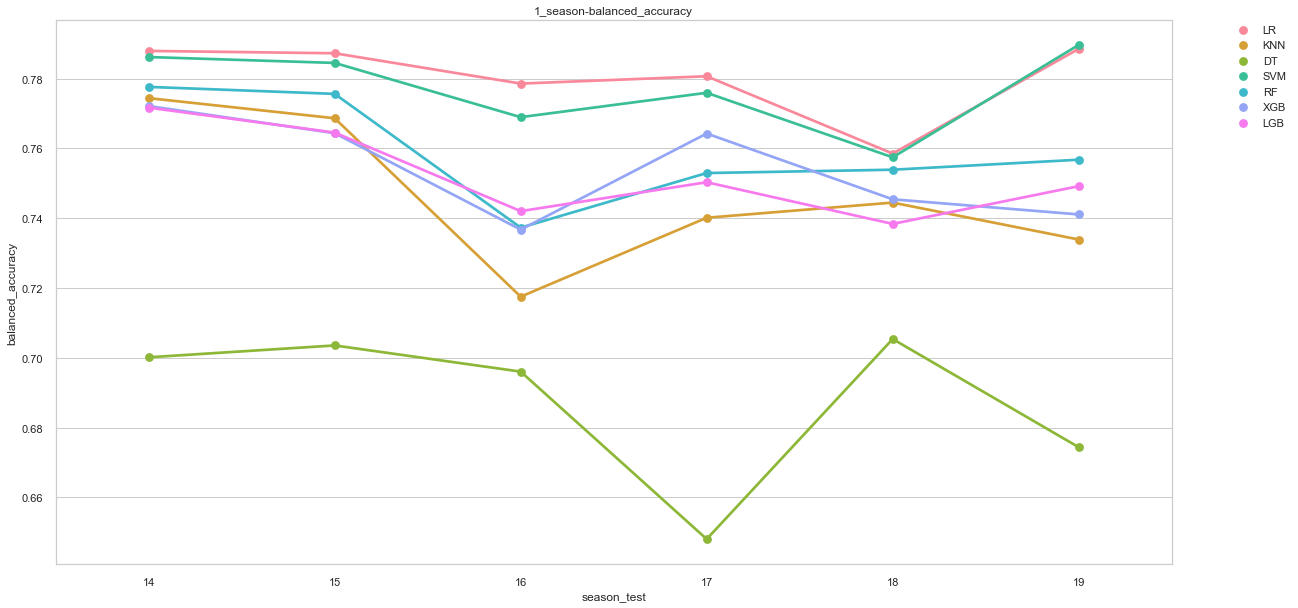

In [61]:
#### Visualize experiments results
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de los resultados del experimento se observa lo siguiente:

    - SVM supero con gran ventaja a los demas algoritmos. El algoritmo XGB fue el que mas cerca estuvo a SVM.
    - Se evidencian los siguientes patrones:
        - Para todos los algoritmos hubo una notable mejoria al ser entrenados con la temporada 2014 para predecir la temporada 2015.
        - Sin embargo en las siguientes validaciones para la temporada 2016 y 2017 nuevamente se evidencia una caida en el rendimiento de todos los algoritmos.
        - Para predecir la temporada 2018 pues este rendimiento mejoro.

### Experiment using StandardScaler

In [63]:
experiment_name = f"{exp_prefix}scaled_data"

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
preprocessor = ColumnTransformer([
        ('numerical', num_pipeline, model_config.X_COLS)
    ], remainder='passthrough')
#transformed_data = preprocessor.fit_transform(df)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment scaled_data
Done


,exp_name,model,roc_auc_mean,roc_auc_std
10,scaled_data,LR,0.778341,0.008131
17,scaled_data,LR,0.778341,0.008131
13,scaled_data,SVM,0.772985,0.010027
20,scaled_data,SVM,0.772985,0.010027
14,scaled_data,RF,0.758934,0.014034
21,scaled_data,RF,0.758934,0.014034
15,scaled_data,XGB,0.753640,0.013484
22,scaled_data,XGB,0.753640,0.013484
16,scaled_data,LGB,0.752528,0.010076
23,scaled_data,LGB,0.752528,0.010076


- Respecto a la metrica balanced_accuracy se observa lo siguiente:

    - ***XGB***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***RF***: Obtuvo el segundo promedio mas alto.
    - ***LGB***: Obtuvo el tercer promedio mas alto.

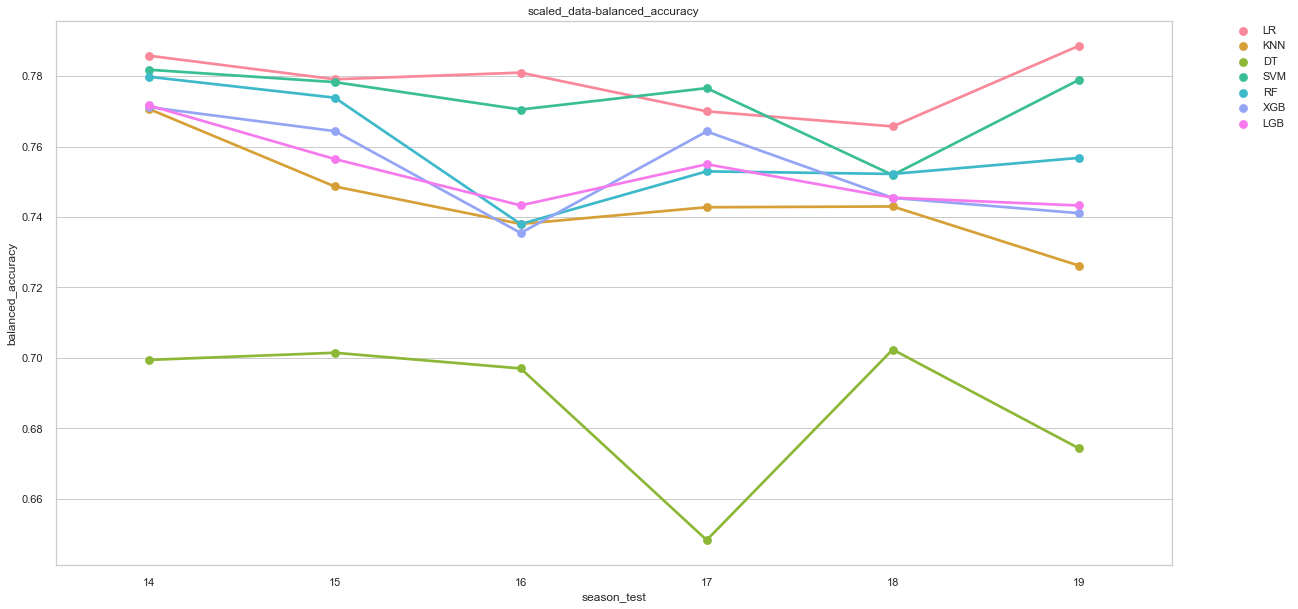

In [64]:
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de los resultados del experimento se observa lo siguiente:

    - A pesar de que obtuvo el mejor rendimiento en la primera validacion, el algoritmo SVM empeoro en cada validacion. Cabe señalar tambien que ademas de que cayo empicado arrojo un rendimiento de un 50% para la ultima validacion.
    - Para los demas algoritmos se evidencia un patron en la validacion de predecir al temporada 15 donde para todos fue un mejor rendimiento que para predecir la temporada 14.
    - Para la temporada 16 el rendimiento bajo para todos.
    - Para la temporada 17 el algoritmo KNN presenta una notable mejoria por enciman de los demas algoritmos.
    - Para la ultima temporada el algoritmo XGB fue el que obtuvo el mejor rendimiento.

### Experiment using MinMaxScaler

In [68]:
experiment_name = f"{exp_prefix}minmax_data"

num_pipeline = Pipeline([
    ('minmax_scaler', MinMaxScaler())
])
preprocessor = ColumnTransformer([
        ('numerical', num_pipeline, model_config.X_COLS)
    ], remainder='passthrough')
#transformed_data = preprocessor.fit_transform(df)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment minmax_data
Done


,exp_name,model,roc_auc_mean,roc_auc_std
27,minmax_data,SVM,0.777829,0.006862
24,minmax_data,LR,0.777770,0.005737
28,minmax_data,RF,0.760074,0.013776
25,minmax_data,KNN,0.758201,0.010619
29,minmax_data,XGB,0.753846,0.013632
30,minmax_data,LGB,0.750258,0.011822
26,minmax_data,DT,0.688056,0.020985


- Respecto a la metrica balanced_accuracy se observa lo siguiente:

    - ***XGB***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***RF***: Obtuvo el segundo promedio mas alto.
    - ***LGB***: Obtuvo el tercer promedio mas alto.

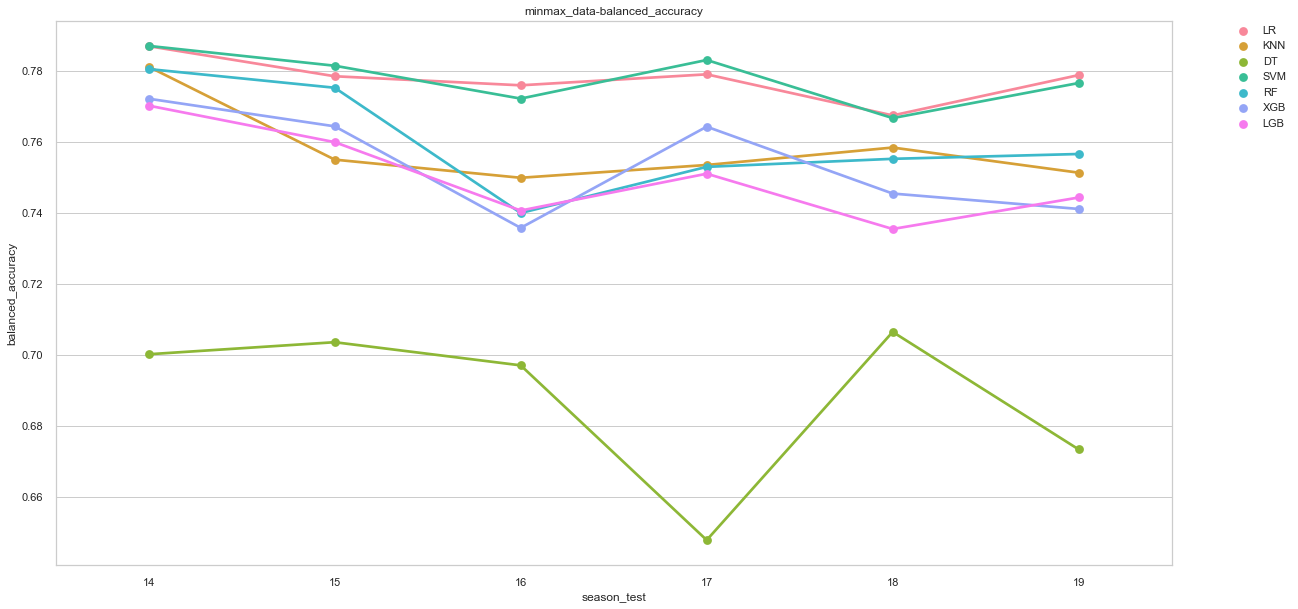

In [69]:
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de los resultados del experimento se observa lo siguiente:

    - A pesar de que obtuvo el mejor rendimiento en la primera validacion, el algoritmo SVM empeoro en cada validacion. Cabe señalar tambien que ademas de que cayo empicado arrojo un rendimiento de un 50% para la ultima validacion.
    - Para los demas algoritmos se evidencia un patron en la validacion de predecir al temporada 15 donde para todos fue un mejor rendimiento que para predecir la temporada 14.
    - Para la temporada 16 el rendimiento bajo para todos.
    - Para la temporada 17 el algoritmo KNN presenta una notable mejoria por enciman de los demas algoritmos.
    - Para la ultima temporada el algoritmo XGB fue el que obtuvo el mejor rendimiento.

### Experiment: train: 2s; test: 1s

In [70]:
experiment_name = f"{exp_prefix}2_seasons"

folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment 2_seasons
Done


,exp_name,model,roc_auc_mean,roc_auc_std
31,2_seasons,LR,0.782677,0.008121
34,2_seasons,SVM,0.781626,0.005909
35,2_seasons,RF,0.766163,0.006284
37,2_seasons,LGB,0.758220,0.006782
36,2_seasons,XGB,0.758131,0.008643
32,2_seasons,KNN,0.748068,0.014390
33,2_seasons,DT,0.687840,0.013786


- Respecto a la metrica balanced_accuracy se observa lo siguiente:

    - ***SVM***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***LGB***: Obtuvo el segundo promedio mas alto.
    - ***XGB***: Obtuvo el tercer promedio mas alto.

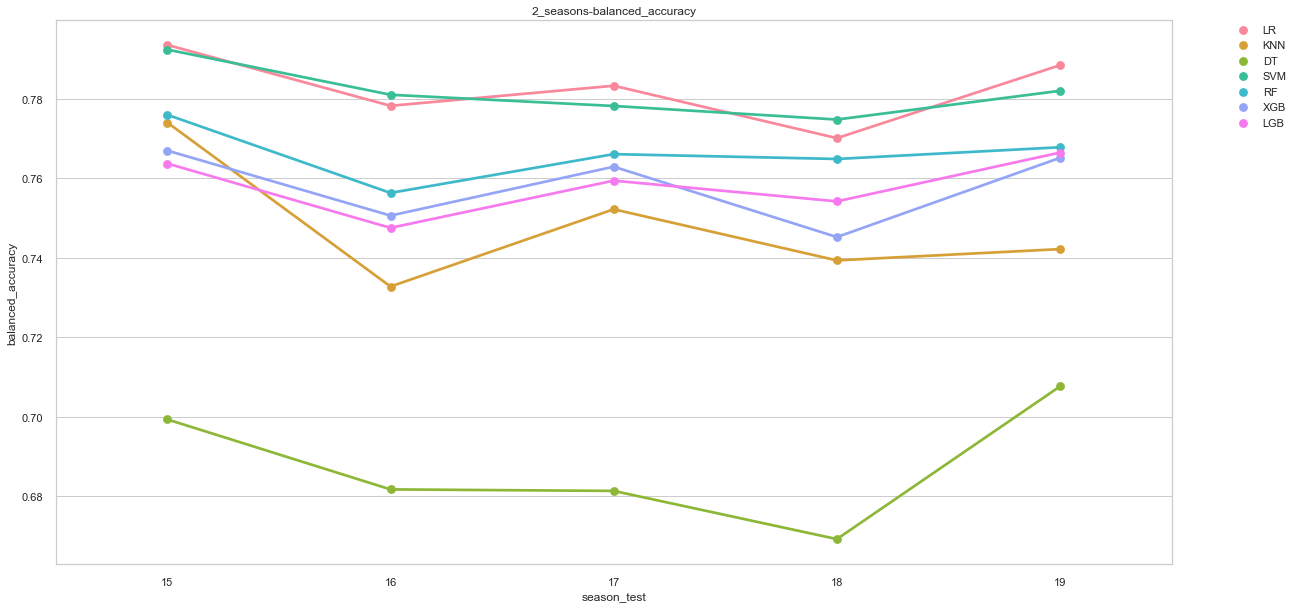

In [71]:
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de los resultados del experimento se observa lo siguiente:

    - Claramente SVM fue el algoritmo que mejor rendimiento tuvo en cada una de las validaciones.
    - Se evidencia un patron en el que todos los algoritmos tuvieron una caida de su rendimiento en la temporada 16 y continuo cayendo en el 17, a excepcion de RF que mejoro.
    - Otro patron que se evidencia es que para la temporada 2018 todos los algoritmos mejoraron.


### Experiment: train: 3s; test: 1s

In [72]:
experiment_name = f"{exp_prefix}3_seasons"

folds, train_seasons, test_seasons = sscv.split(train_size=3, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment 3_seasons
Done


,exp_name,model,roc_auc_mean,roc_auc_std
38,3_seasons,LR,0.783168,0.003503
41,3_seasons,SVM,0.782053,0.005573
42,3_seasons,RF,0.762544,0.007694
44,3_seasons,LGB,0.760184,0.007527
43,3_seasons,XGB,0.759003,0.008412
39,3_seasons,KNN,0.742285,0.004976
40,3_seasons,DT,0.696434,0.017371


- Respecto a la metrica balanced_accuracy se observa lo siguiente:

    - ***SVM***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***LGB***: Obtuvo el segundo promedio mas alto.
    - ***XGB***: Obtuvo el tercer promedio mas alto.

 Se destaca tambien que estos resultados son muy similares a los del experimento anterior(2s 1s)

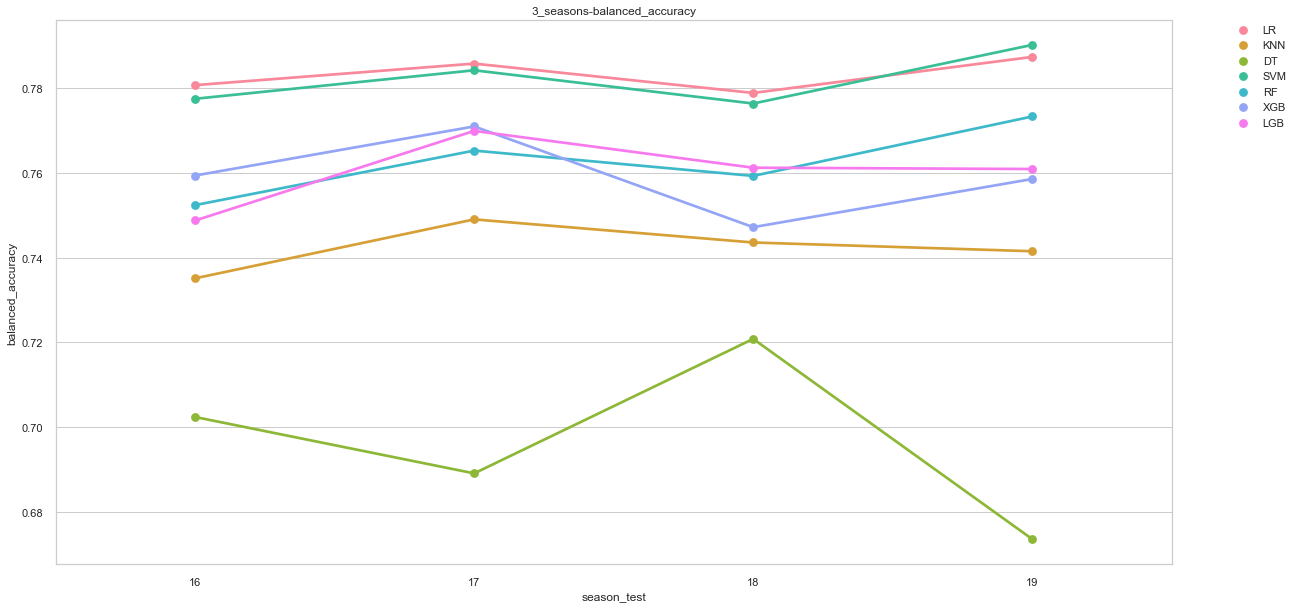

In [74]:
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de cada validacion se observa lo siguiente:

    - Nuevamente SVM fue el algoritmo que mejor rendimiento tuvo en cada una de las validaciones.
    - Se evidencia un ligero patron de ascenso para los tres algoritmos con mejor rendimiento, lo cual indica cierta estabilidad en las validaciones de este experimento comparada con los experimentos anteriores.
    - Tambien se evidencia que comparado con los experimentos anteriores, en este el peor rendimiento estuvo en la primera validacion la del 16.

### Experiment train: 3q ; test: 1q

In [75]:
experiment_name = f"{exp_prefix}3q_1q"

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment 3q_1q
Done


,exp_name,model,roc_auc_mean,roc_auc_std
45,3q_1q,LR,0.767468,0.035726
48,3q_1q,SVM,0.764719,0.034466
49,3q_1q,RF,0.756327,0.023824
51,3q_1q,LGB,0.750759,0.022214
50,3q_1q,XGB,0.746722,0.019767
46,3q_1q,KNN,0.739851,0.021994
47,3q_1q,DT,0.683942,0.030592


- Respecto a la metrica balanced_accuracy se observa lo siguiente:

    - ***LGB***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***KNN***: Obtuvo el segundo promedio mas alto.
    - ***SVM***: Obtuvo el tercer promedio mas alto.

 Comparado con el anterior experimento(3s 1s), estos resultados son peores, pero es importante destacar que se hicieron muchisimas mas validaciones que los experimentos anteriores. Ver grafico debajo.

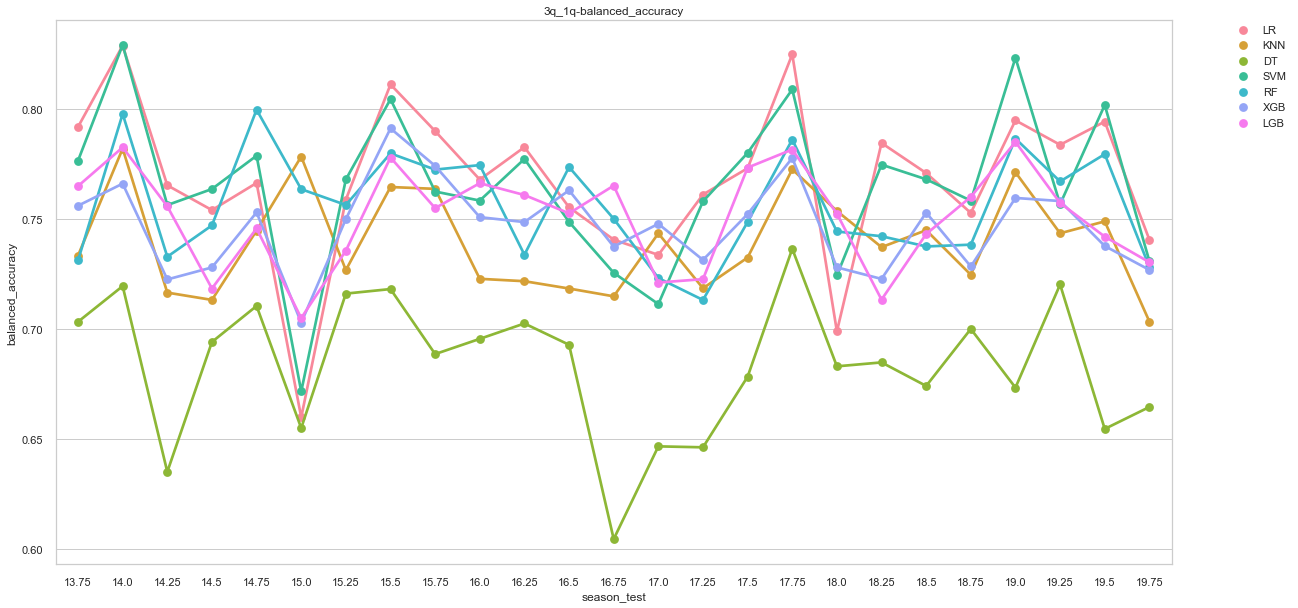

In [76]:
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de cada validacion se observa lo siguiente:

    - SVM fue bastante inestable, tuvo casi igual de picos de buenos rendimientos como caidas de malos rendientos.
    - Se observa un patron, en cada cuarto de temporada 0.25, que corresponde a la mitad(desde 0.25 a 0.5) pues el rendimiento de cada algoritmo tuvo una caida.

### Experiment train: 4q ; test: 2q

In [77]:
experiment_name = f"{exp_prefix}4q_2q"

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment 4q_2q
Done


,exp_name,model,roc_auc_mean,roc_auc_std
52,4q_2q,LR,0.778277,0.017891
55,4q_2q,SVM,0.777408,0.018717
56,4q_2q,RF,0.759072,0.015400
57,4q_2q,XGB,0.753470,0.017446
58,4q_2q,LGB,0.752734,0.016580
53,4q_2q,KNN,0.746689,0.017449
54,4q_2q,DT,0.686730,0.021938


- Respecto a la metrica balanced_accuracy se observa lo siguiente:

    - ***SVM***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***XGB***: Obtuvo el segundo promedio mas alto.
    - ***RF***: Obtuvo el tercer promedio mas alto.


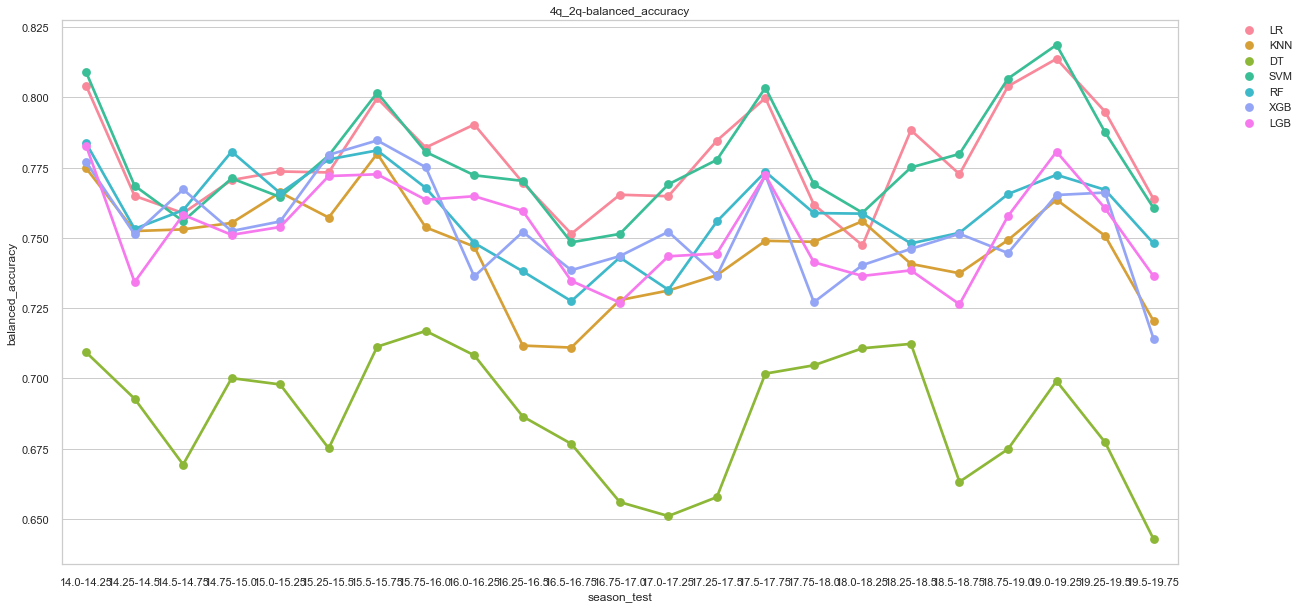

In [78]:
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de cada validacion se observa lo siguiente:

    - SVM fue un poco mas estable que el experimento anterior.
    - Se observa un patron, en cada validacion 0.5-0.75, es decir, que se trata de predecir la segunda mitad de la temporada, usando la primera mitad de la temporada actual y la ultima mitad de la anterior, pues hay una caida en el rendimiento de los algoritmos.

### Experiment remove first 1q ; train: 2q ; test: 1q

En este experimento se eliminara el primer cuarto de cada temporada, y se entrenara el modelo con los 2 siguientes cuartos, y como test 1 cuarto de temporada. La ventana deslisante sera de 1 cuarto.

In [79]:
experiment_name = f"{exp_prefix}r1q_2q_1q"

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=2, test_size=1, skip=[0.25])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment r1q_2q_1q
Done


,exp_name,model,roc_auc_mean,roc_auc_std
59,r1q_2q_1q,LR,0.769442,0.025525
62,r1q_2q_1q,SVM,0.766275,0.024159
63,r1q_2q_1q,RF,0.757108,0.020682
65,r1q_2q_1q,LGB,0.750440,0.018532
64,r1q_2q_1q,XGB,0.748461,0.019934
60,r1q_2q_1q,KNN,0.739513,0.018492
61,r1q_2q_1q,DT,0.682447,0.029494


- Respecto a la metrica balanced_accuracy se observa lo siguiente:

    - ***KNN***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***LGB***: Obtuvo el segundo promedio mas alto.
    - ***SVM***: Obtuvo el tercer promedio mas alto.


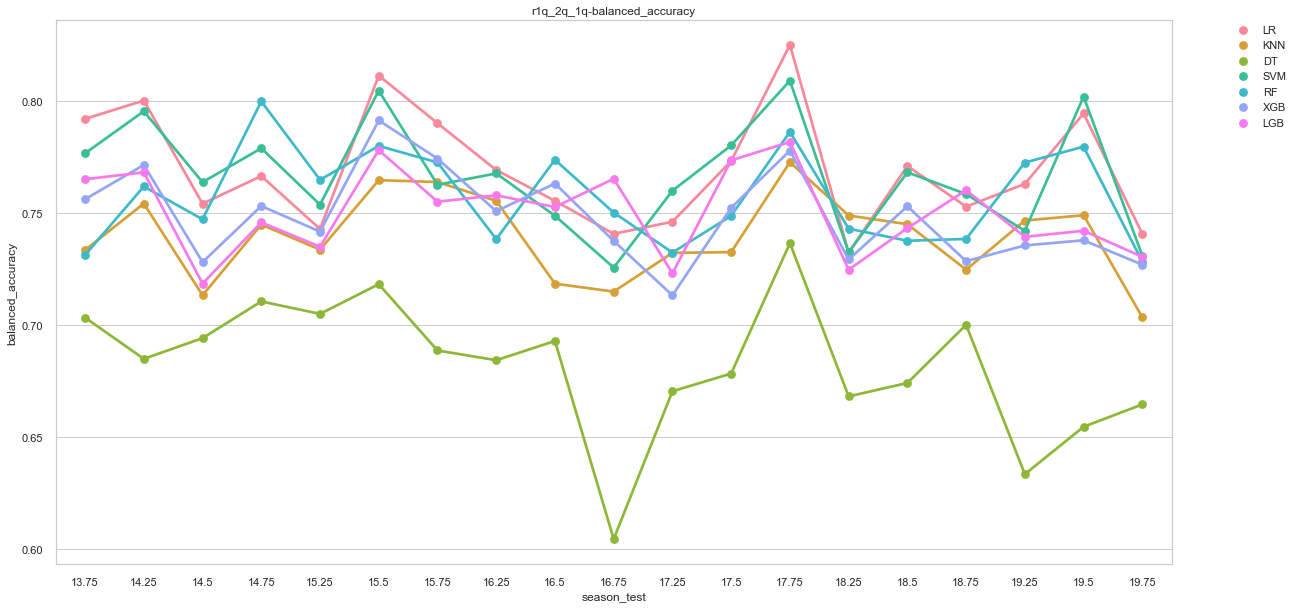

In [80]:
#### Visualize experiments results
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de cada validacion se observa lo siguiente:

    - Se observa un patron, en cada validacion .75, es decir, que se trata de predecir el ultimo cuarto de temporada, pues hay una caida del rendimiento en el caso del algoritmo SVM, sin embargo no es lo mismo para los otros algoritmos, al menos no para todos las validaciones .75.

### Experiments comparison

In [81]:
utils.serialize_object(exp_group_name, utils_exp.exp_results)

In [82]:
exp_df = get_results_df()

In [83]:
ba_df = exp_df[['exp_name', 'model',
       'balanced_accuracy_mean', 'balanced_accuracy_std']]

In [84]:
#show_qgrid(exp_df)
qgrid_widget = qgrid.show_grid(ba_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [85]:
ba_df.sort_values(
    by=["balanced_accuracy_mean"]
    , ascending=False)[:6].reset_index().drop(labels=["index"], axis=1)

,exp_name,model,balanced_accuracy_mean,balanced_accuracy_std
0,3_seasons,LR,0.783168,0.003503
1,2_seasons,LR,0.782677,0.008121
2,3_seasons,SVM,0.782053,0.005573
3,2_seasons,SVM,0.781626,0.005909
4,1_season,LR,0.780261,0.010426
5,scaled_data,LR,0.778341,0.008131


Basado en la metrica 'balanced_accuracy_mean' se observa:

- El algoritmo SVM obtuvo el mejor rendimiento para la mayoria de los experimentos. LGB fue el algoritmo siguiente que obtuvo el mejor rendimiento.
- En los experimentos que se obtuvo el mejor rendimiento fueron usando 2 y 3 temporadas para entrenamiento para predecir al siguiente.


### Plot experiment results

In [86]:
utils.serialize_object("results", utils_exp.exp_results)
utils.serialize_object("results_total", results_total)

#### Balance Accuracy

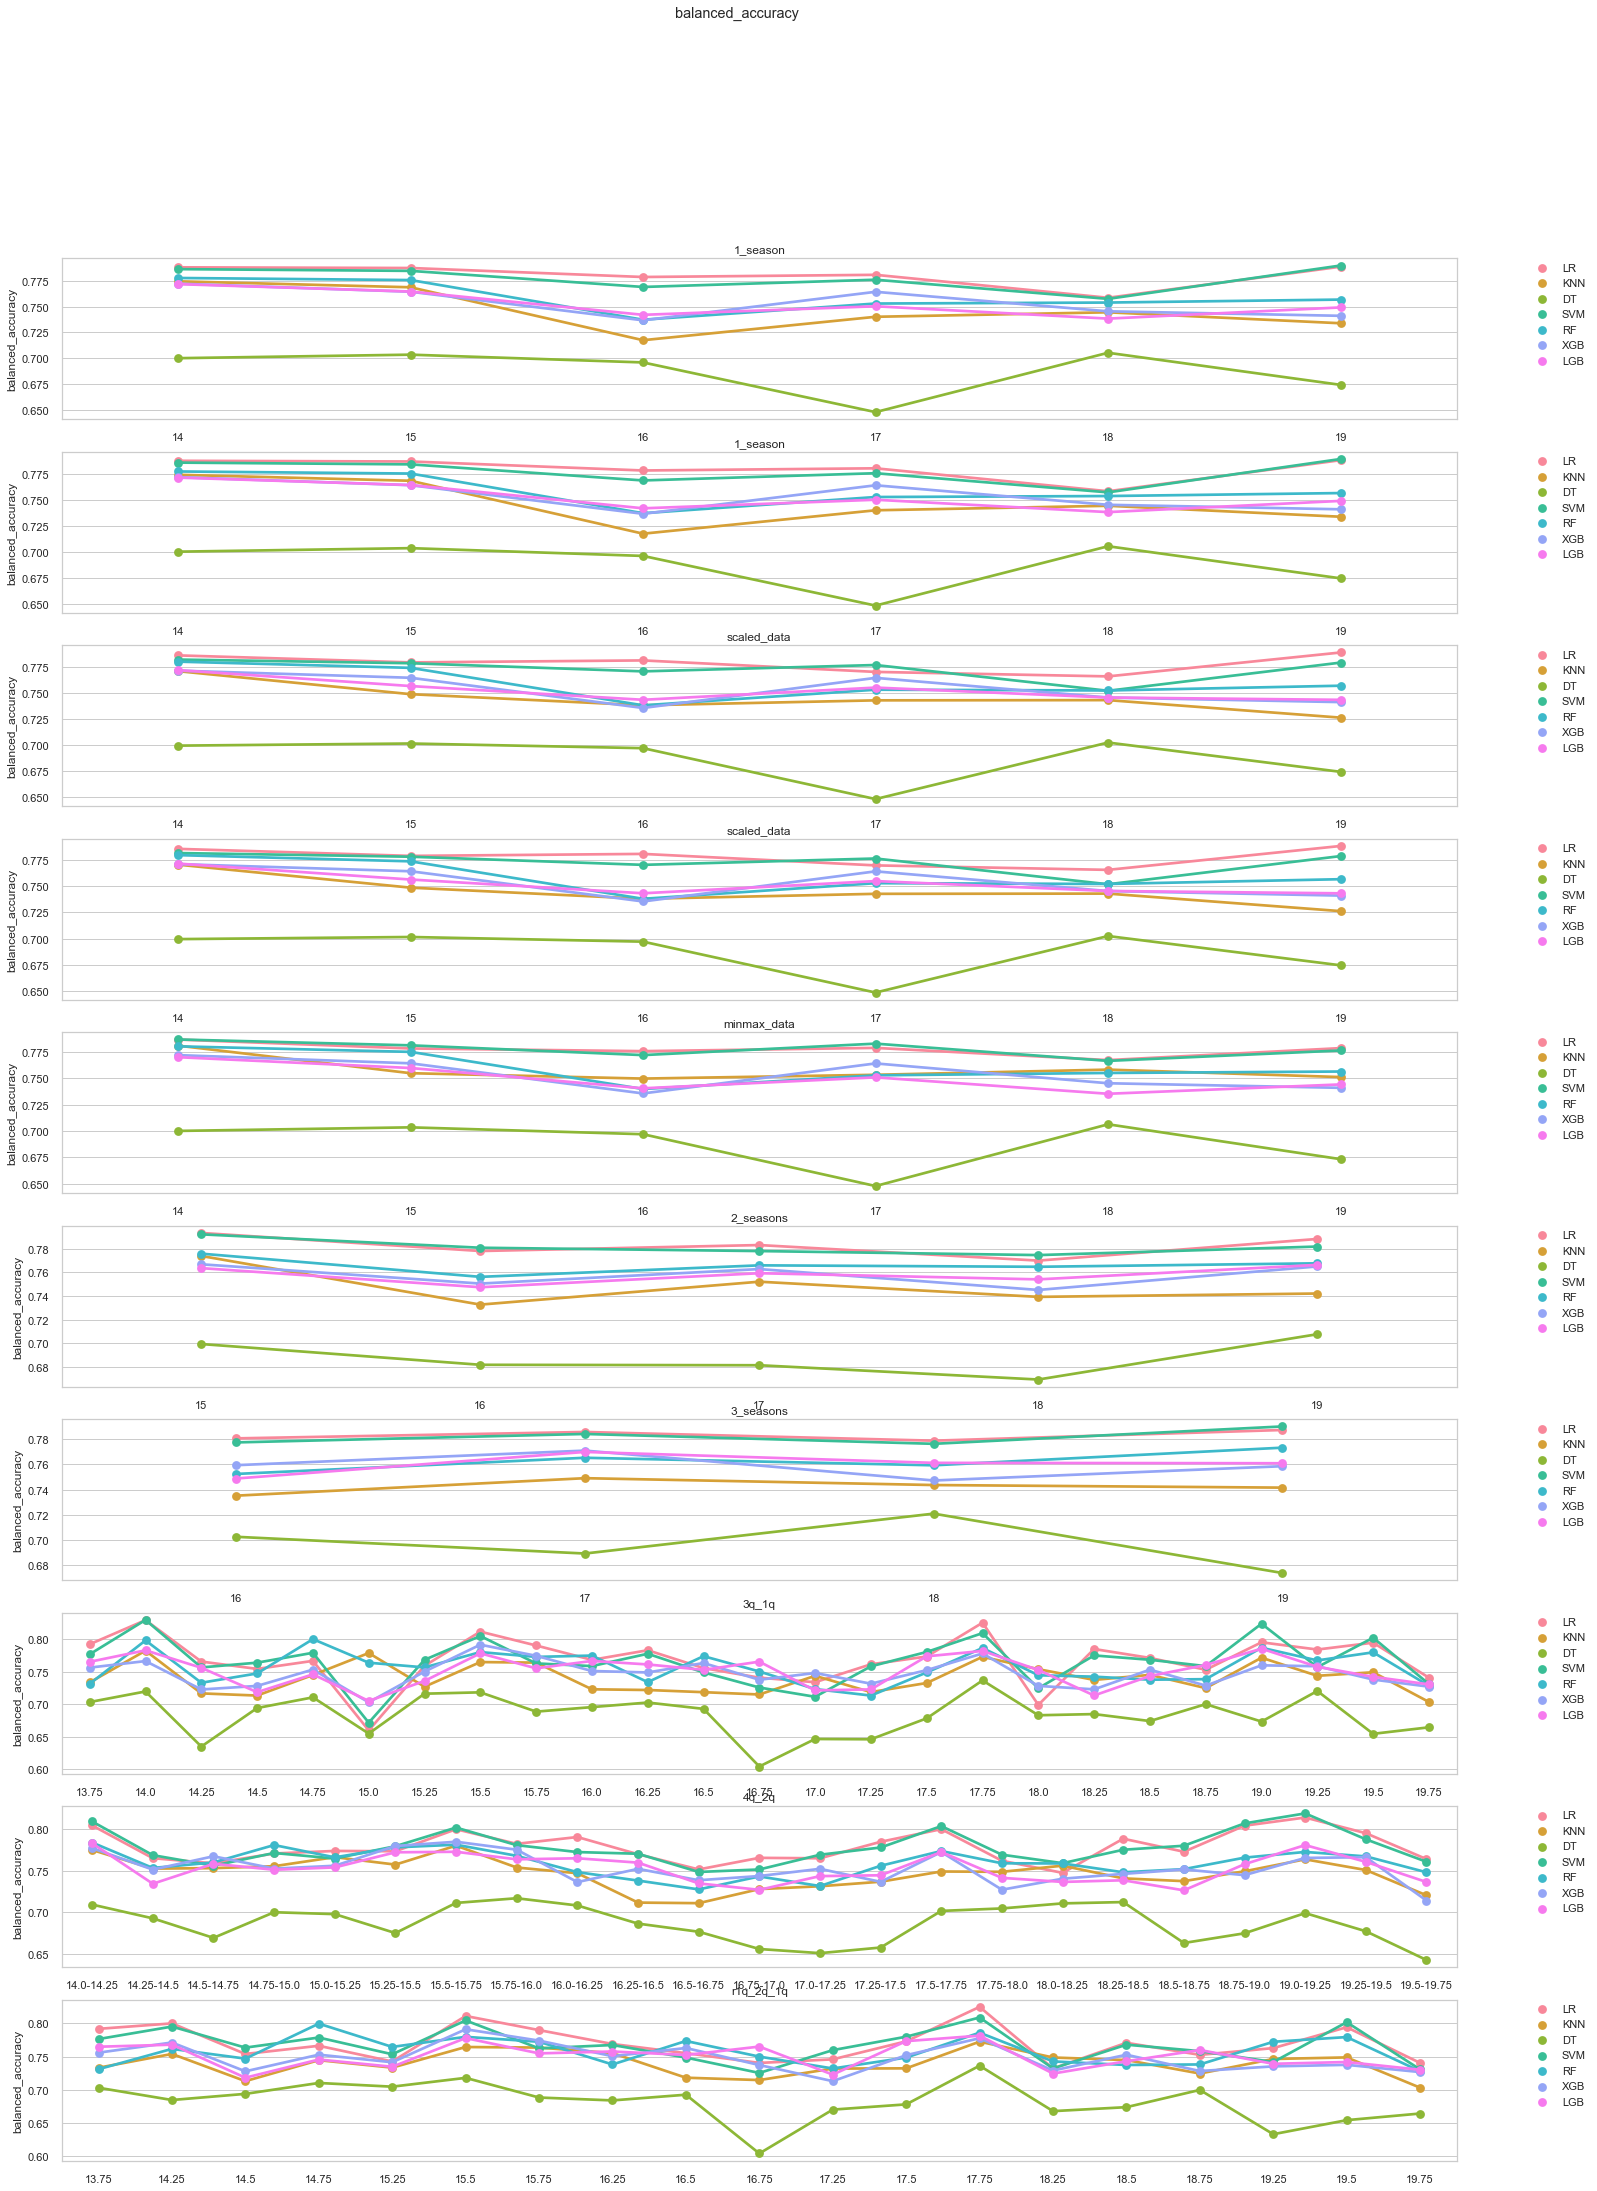

In [87]:
utils.plot_to_compare_experiments(
    results_total,
    metric="balanced_accuracy",
    figsize=(25, 35),
    use_pointplot=True
)

#### Precision

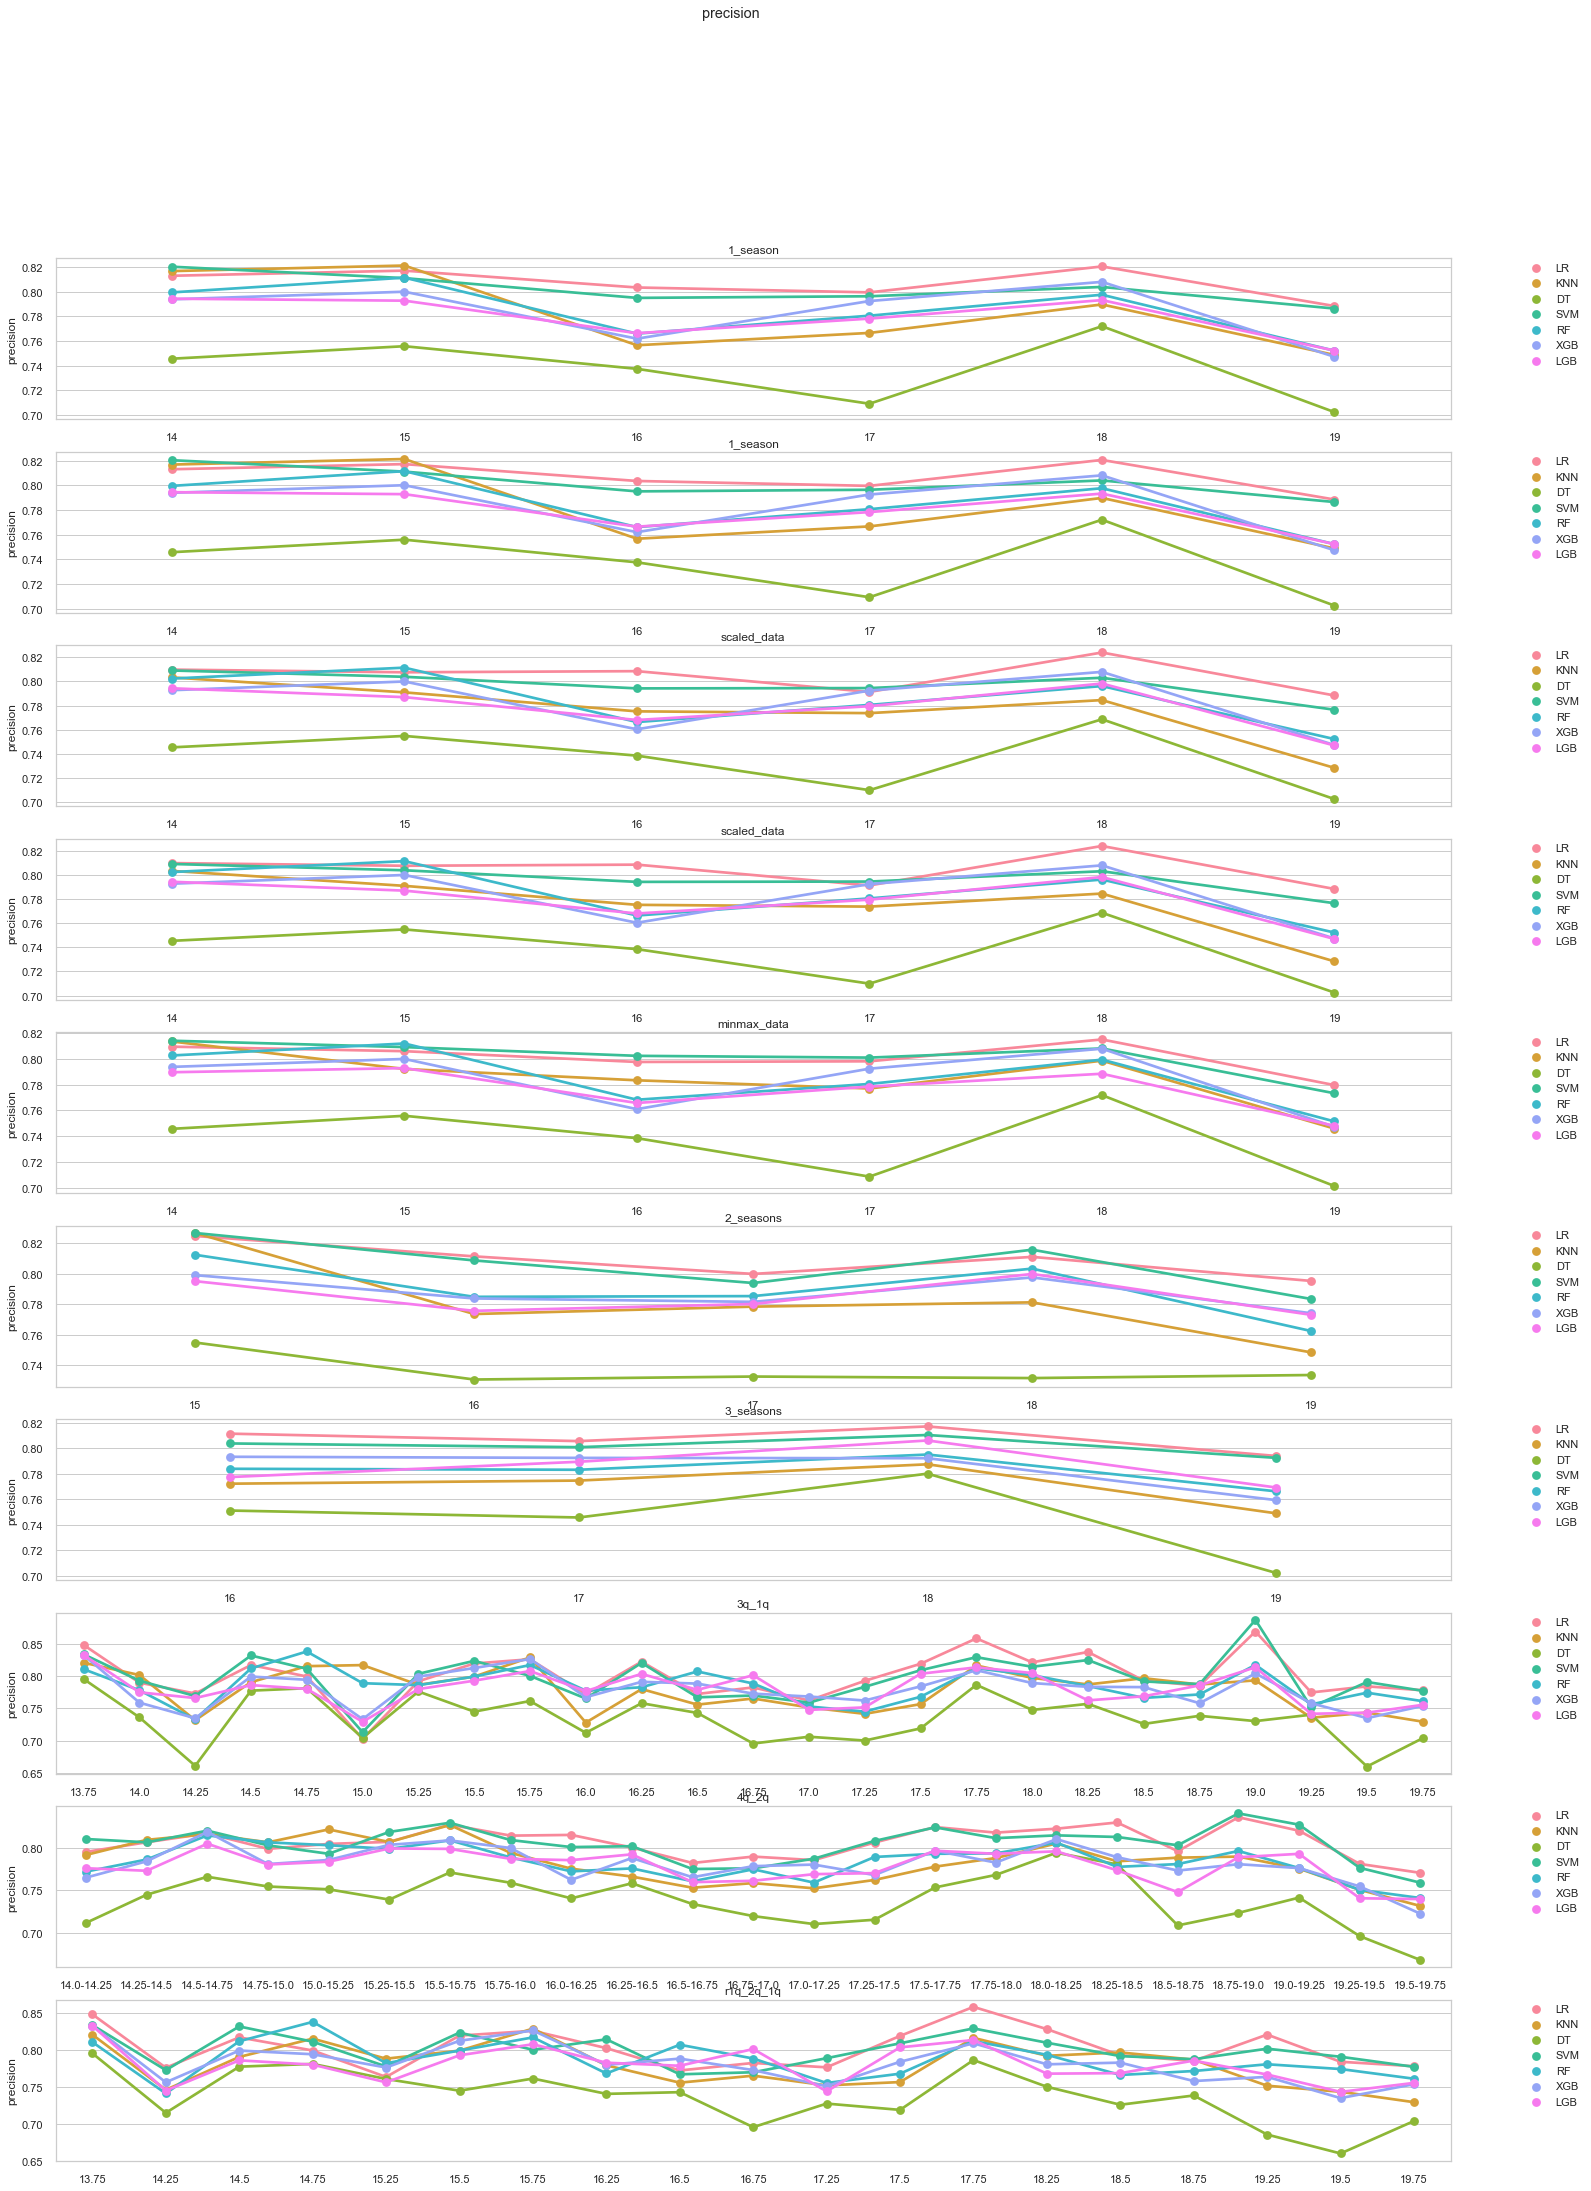

In [88]:
utils.plot_to_compare_experiments(
    results_total,
    metric="precision",
    figsize=(25, 35),
    use_pointplot=True
)

#### ROC AUC

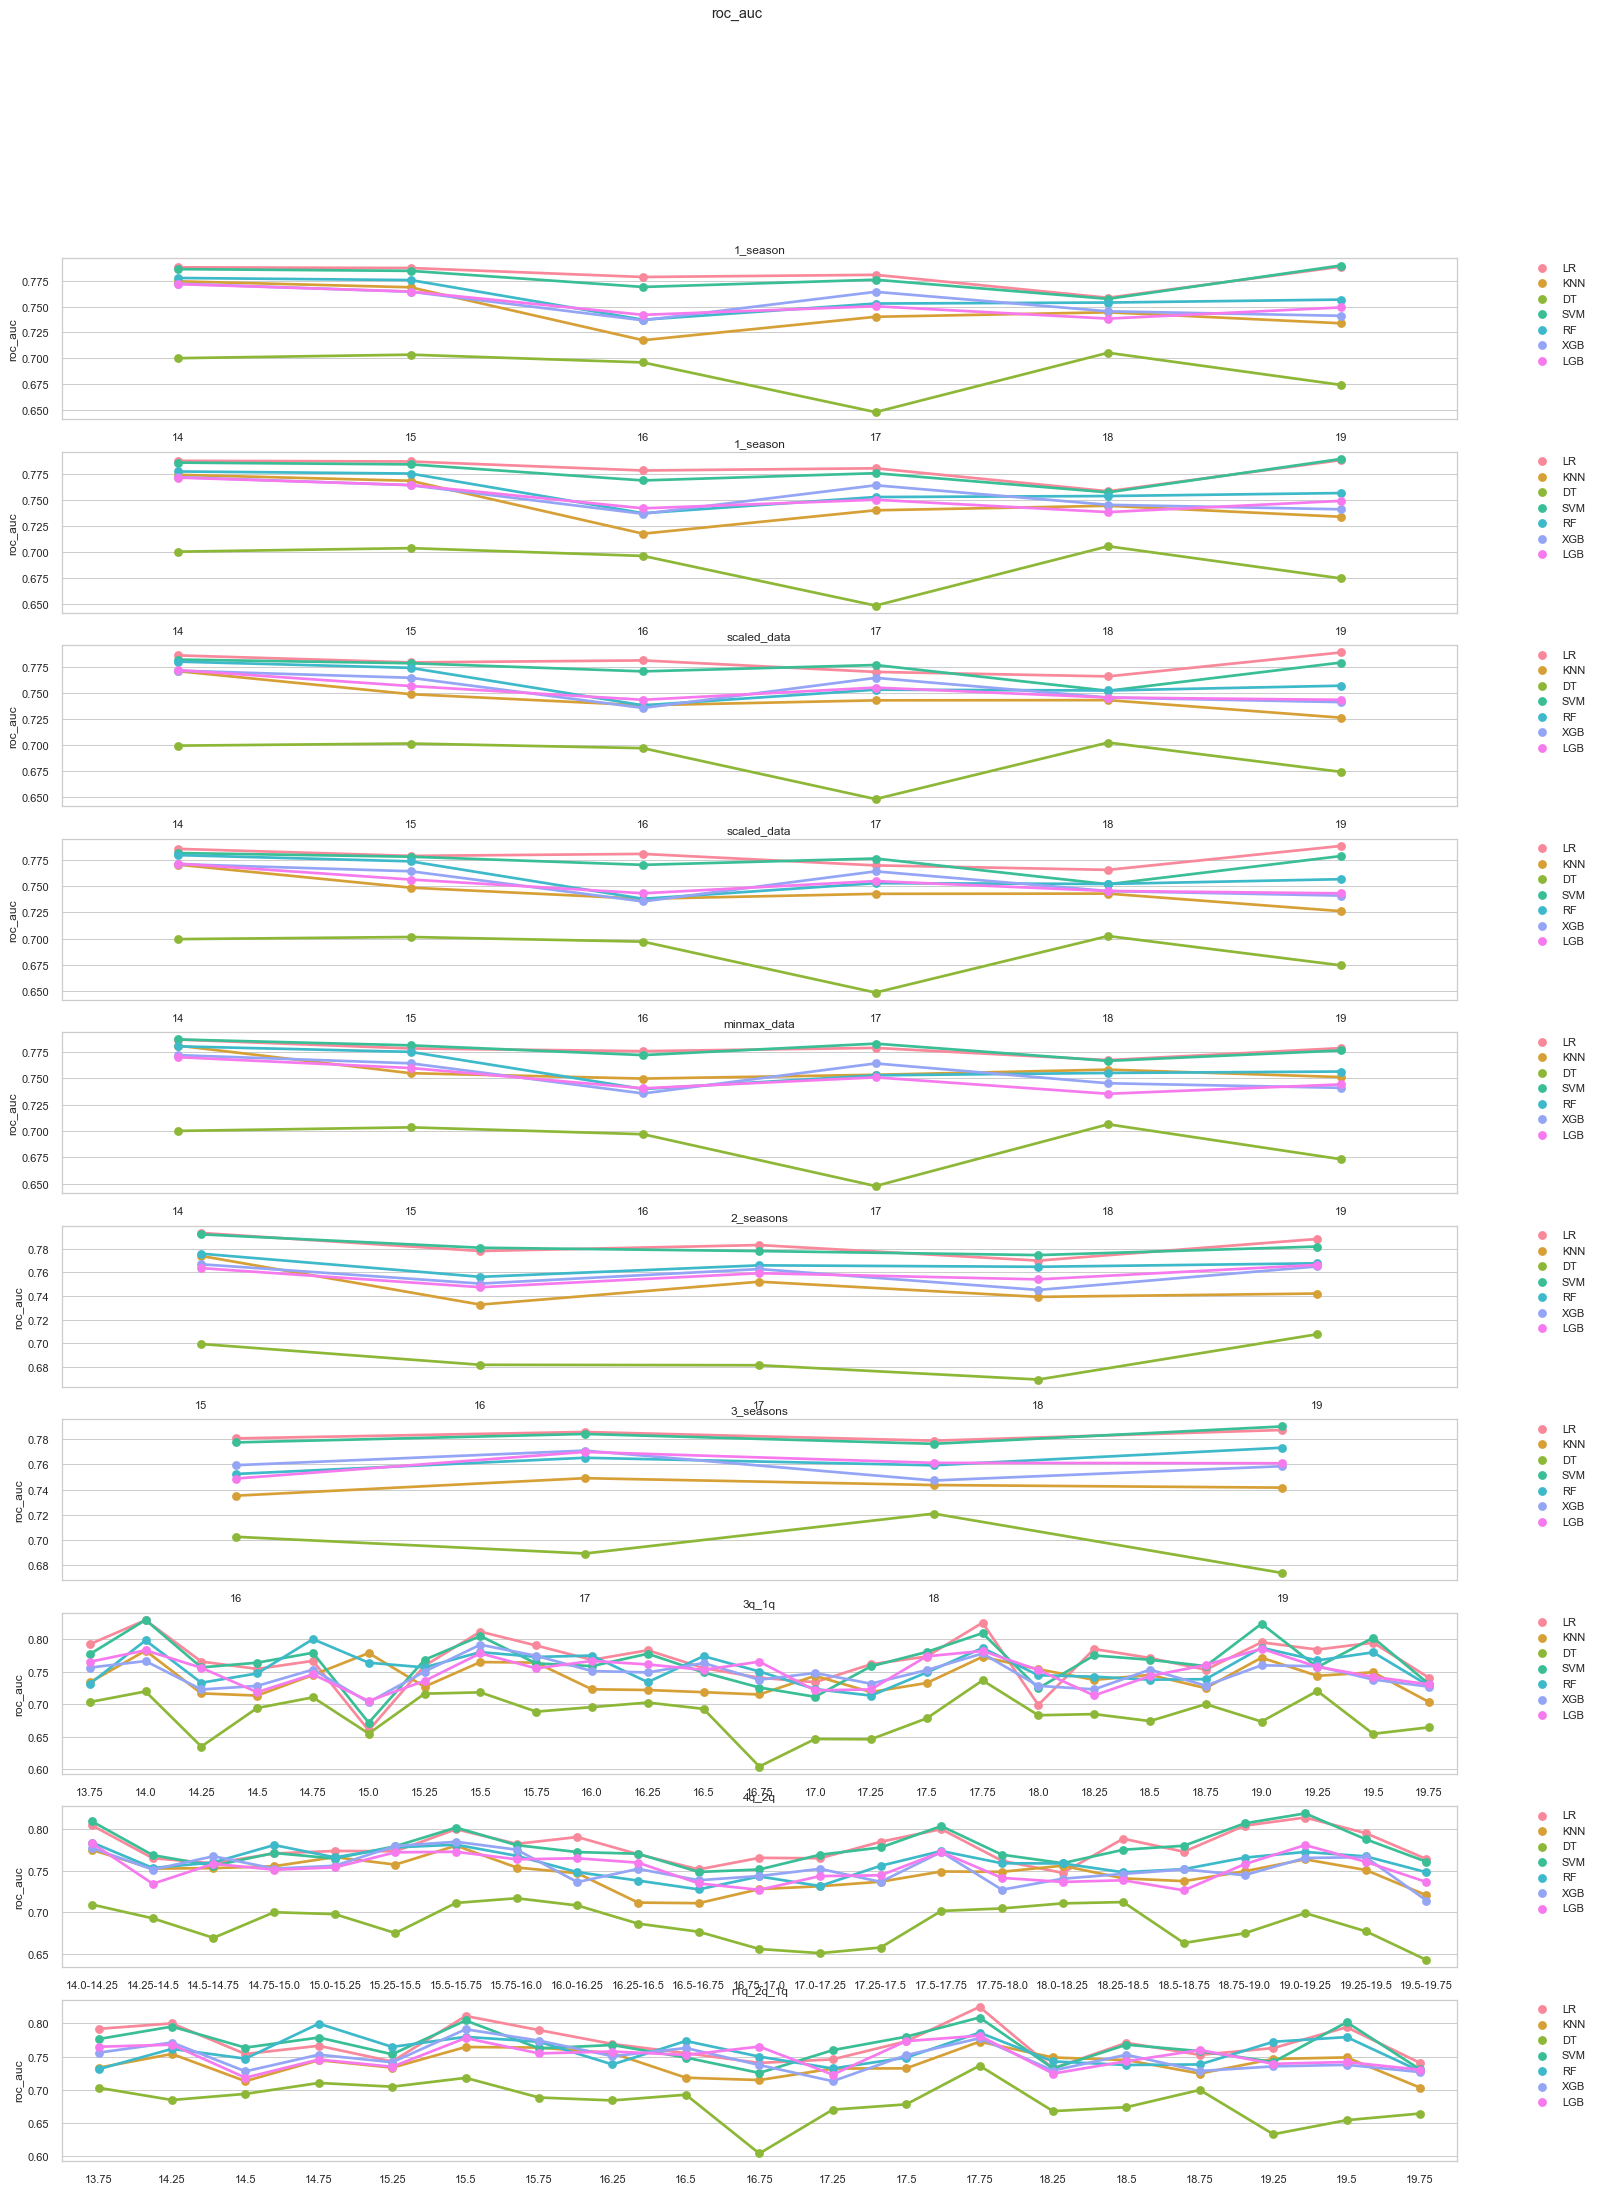

In [91]:
utils.plot_to_compare_experiments(
    results_total,
    metric="roc_auc",
    figsize=(25, 35),
    use_pointplot=True
)